### DONE
- FT-HMC implemented for 8x8 2D QED (using SiLU as activation function).

- Try to minimize size of the force in training. No significant improvements.

- Some test on ergodicity

- (calculate the probablity of generating the configs obtained via conventional HMC).

### TODO

- Plot the force size distribution
- Is the large force from the original action or Field-Transformation the determinant?
- If from the determinant, then the fermion force won't cause problem for HMC

- Use the same Field-Transformation for larger system (say 16x16, 32x32, 64x64, etc)
- Study how the delta H depends on the system size ( perhaps delta H ~ sqrt(volume) )

- Study the auto-correlation for observables, topo, plaq, flowed plaq, etc.

- Improving the Field-Transformation to reduce force.

In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format ='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import math
import sys
import os
from timeit import default_timer as timer
from functools import reduce

In [3]:
from datetime import datetime as dt

try:
    from rich.theme import Theme
    from rich.console import Console
    from rich.style import Style

    theme = Theme({
        'repr.number': 'bold bright_green',
        'repr.attrib_name': 'bold bright_magenta'
    })
    console = Console(record=False, log_path=False, width=256,
                      log_time_format='[%X] ', theme=theme)
    RICH = True
    def put(s):
        console.log(s)
    
    
except (ImportError, ModuleNotFoundError):
    RICH = False
    def put(s):
        print(s)

In [4]:
project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
    
from utils.param import Param

In [5]:
def print_metrics(history, avg_last_n_epochs=10, era=None, epoch=None):
    outstr = []
    
    if era is not None:
        outstr.append(f'era: {era}')
    if epoch is not None:
        outstr.append(f'epoch: {epoch}')
        
    for key, val in history.items():
        val = np.array(val)
        if len(val.shape) > 0:
            avgd = np.mean(val[-avg_last_n_epochs:])
        else:
            avgd = np.mean(val)
        outstr.append(f'{key}: {avgd:g}')
        
    outstr = ', '.join(outstr)
    put(outstr)
    
    return outstr

In [6]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 1, # 0.3
    nstep = 8, # 3
    nrun = 8,
    # ADJUST ME
    ntraj = 128, # 2**16 # 2**10 # 2**15
    nprint = 10,
    seed = 1331
)

put(param.summary())

In [7]:
torch.manual_seed(param.seed)

torch.set_num_threads(param.nth)
torch.set_num_interop_threads(param.nth_interop)
os.environ["OMP_NUM_THREADS"] = str(param.nth)
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

torch.set_default_tensor_type(torch.DoubleTensor)

In [12]:
import utils.qed_helpers as qed
import ipynb.field_transformation as ft
import datetime

def get_timestamp(fstr=None):
    """Get formatted timestamp."""
    now = datetime.datetime.now()
    if fstr is None:
        return now.strftime('%Y-%m-%d-%H%M%S')
    return now.strftime(fstr)



def run(param, field = None, keep_fields=False):
    if field is None:
        field = param.initializer()
        
    fields = {i: [] for i in range(param.nrun)}
    metrics = {
        'dt': [],
        'accept': [],
        'traj': [],
        'dH': [],
        'expdH': [],
        'plaq': [],
        'charge': [],
    }
    
    
    now = get_timestamp('%Y-%m-%d')
    outdir = os.path.join(os.getcwd(), now)
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
        
    outfile = os.path.join(outdir, param.uniquestr())
    with open(outfile, 'w') as f:
        params = param.summary()
        f.write(params)
        put(params)
        plaq = qed.action(param, field)
        charge = qed.topo_charge(field[None, :])
        status = f"Initial configuration:  plaq: {plaq}  charge: {charge}\n"
        f.write(status)
        put(status)
        #ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                dH, exp_mdH, acc, field = qed.hmc(param, field, verbose=False)
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                charge = qed.topo_charge(field[None, :])
                #topo1 = qed.topo_charge1(field[None, :])
                ifacc = "ACCEPT" if acc else "REJECT"
                observables = {
                    'traj': n * param.ntraj + i + 1,
                    'accept': bool(acc),
                    'dH': dH,
                    'expdH': exp_mdH,
                    'plaq': plaq,
                    'charge': int(qed.grab(charge)[0]),
                }
                
                status = {
                    k: f'{v:<12.8g}' if isinstance(v, float) 
                    else f'{v:<4}' for k, v in observables.items()
                }
                
                outstr = ', '.join(
                    '='.join((k, v)) for k, v in status.items()
                )
                f.write(outstr + '\n')
                
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    put(outstr)
                    
                if keep_fields:
                    fields[n].append(field)
                else:
                    fields[n] = field
                    
            t += timer()
            
            metrics['dt'].append(t)
            for key, val in observables.items():
                metrics[key].append(val)
            
        dt = metrics['dt']
        put(f'Run times: {dt}')
        put(f'Per trajectory: {[t / param.ntraj for t in dt]}')
        
    return fields, metrics

In [13]:
fields, metrics = run(param, keep_fields=False)

## Helper functions for training model

In [14]:
import time
import utils.qed_helpers as qed
from typing import Callable

import torch.nn as nn

from utils.layers import make_u1_equiv_layers, set_weights
from utils.distributions import MultivariateUniform, bootstrap, calc_dkl, calc_ess
from utils.samplers import make_mcmc_ensemble, apply_flow_to_prior

from utils.plot_helpers import (init_live_joint_plots, update_joint_plots,
                                init_live_plot, update_plot)

grab = qed.grab

def train_step(
        model,
        action,
        optimizer,
        metrics,
        batch_size,
        with_force=False,
        pre_model=None,
        verbose=True,
        era=None,
        epoch=None,
        #gamma=None,  # annealing factor, should be in [0, 1]
):
    t0 = time.time()
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()
    
    xi = None
    if pre_model != None:
        pre_layers, pre_prior = pre_model['layers'], pre_model['prior']
        pre_xi = pre_prior.sample_n(batch_size)
        x = qed.ft_flow(pre_layers, pre_xi)
        xi = qed.ft_flow_inv(layers, x)
        
    xi, x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size, xi=xi)#, gamma=gamma)
    logp = -action(x)
    
    force_size = torch.tensor(0.0)
    dkl = calc_dkl(logp, logq)
    loss_force = torch.tensor(0.0)
    loss_dkl = torch.tensor(0.0)
    if with_force:
        assert pre_model != None
        force = qed.ft_force(param, layers, xi, True)
        force_size = torch.sum(torch.square(force))
        loss_force = force_size
        loss_force.backward()
    else:
        loss_dkl = dkl
        loss_dkl.backward()
        
    #loss.backward()
    #
    # minimization target
    # loss mini
    # -> (logq - logp) mini
    # -> (action - logJ) mini
    #
    optimizer.step()
    ess = calc_ess(logp, logq)
    batch_metrics = {
        'dt': time.time() - t0,
        #'loss': grab(loss),
        'loss_force': grab(loss_force),
        'loss': grab(loss_dkl),
        'force': grab(force_size),
        'dkl': grab(dkl),
        'logp': grab(logp),
        'logq': grab(logq),
        'ess': grab(ess),
        'force_norm': grab(torch.linalg.norm(qed.ft_force(param, layers, xi))),
    }
    if verbose:
        print_metrics(batch_metrics, era=era, epoch=epoch)
        
    for key, val in batch_metrics.items():
        if key in metrics:
            if 'loss' in key:
                if with_force:
                    metrics['loss_force'].append(val)
                else:
                    metrics['loss'].append(val)
            else:
                metrics[key].append(val)
                

            
def flow_train(
    param,
    n_era=10,
    n_epoch=100,
    n_layers=24,
    n_s_nets=2,
    hidden_sizes=[8, 8],
    kernel_size=3,
    base_lr=0.001,
    batch_size=64,
    print_freq=10,
    plot_freq=20,
    with_force=False,
    pre_model=None
):  # packaged from original ipynb by Xiao-Yong Jin
    # Theory
    lattice_shape = param.lat
    link_shape = (2,*param.lat)
    beta = param.beta
    #u1_action = U1GaugeAction(beta)
    u1_action = qed.BatchAction(param.beta)
    # Model
    prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
    
    layers = make_u1_equiv_layers(lattice_shape=lattice_shape,
                                  n_layers=n_layers,
                                  n_mixture_comps=n_s_nets,
                                  hidden_sizes=hidden_sizes,
                                  kernel_size=kernel_size)
    set_weights(layers)
    
    model = {'layers': layers, 'prior': prior}
    
    # Training
    optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)
    optimizer_wf = torch.optim.Adam(model['layers'].parameters(), lr=base_lr / 100.0)
    #
    history = {
        'dt': [], 'force' : [], 'force_norm': [], 'ess' : [],
        'dkl' : [], 'logp' : [], 'logq' : [],
        #'loss' : [], 'loss_dkl': [], 'loss_force': [],
    }
    if with_force:
        history.update({
            'loss_force': [], 
            'loss': [],
        })
    else:
        history.update({'loss': []})
        #'loss' : [], 'loss_dkl': [], 'loss_force': [],
        
    
    dt = 0.0
    if with_force:
        y_label = ['ESS', 'loss_force']
        joint_plot_dict = init_live_joint_plots(n_era, n_epoch, dpi=125, figsize=(4, 3), param=param, y_label=y_label)
        #plot_dict = init_live_plot(n_era, n_epoch, dpi=125, figsize=(4, 3), param=param, x_label='Epoch', y_label='loss_force')
        
    else:
        joint_plot_dict = init_live_joint_plots(n_era, n_epoch, dpi=125, figsize=(4, 3), param=param)
        
    for era in range(n_era):
        t0 = time.time()
        console.rule(f'ERA: {era} (last took: {int(dt // 60)} min {dt % 60:.4g}s)', style='bright_yellow')
        for epoch in range(n_epoch):
            if with_force:
                train_step(model, u1_action, optimizer_wf, history, batch_size,
                           with_force=with_force, pre_model=pre_model,
                           verbose=(epoch%print_freq==0), era=era, epoch=epoch)
            else:
                train_step(model, u1_action, optimizer, history, batch_size,
                           era=era, epoch=epoch, verbose=(epoch%print_freq==0))
            
                
            if epoch % plot_freq == 0:
                if with_force:
                    update_joint_plots(history, alt_loss='loss', **joint_plot_dict)
                    #update_plot(history['loss_force'], **plot_dict)
                else:
                    update_joint_plots(history, **joint_plot_dict)
                
        dt = time.time() - t0
            
    return model, u1_action



ActionFn = Callable[[float], torch.Tensor]


def generate_ensemble(
    model: nn.Module,
    u1_action: ActionFn = qed.BatchAction,
    ensemble_size: int = 1024,
    batch_size: int = 64,
    nboot: int = 100,
    binsize: int = 16,
):
    """Calculate the topological susceptibility.
    
    Packaged from original ipynb by Xiao-Yong Jin.
    """
    u1_ens = make_mcmc_ensemble(model, u1_action, batch_size, ensemble_size)
    Q = qed.grab(qed.topo_charge(torch.stack(u1_ens['x'], axis=0)))
    X_mean, X_err = bootstrap(Q**2, nboot=nboot, binsize=16)
    
    put(f'Accept rate: {np.mean(u1_ens["accepted"])}')
    put(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
    put(f'... vs HMC estimate = 1.23 +/- 0.02')
    
    return u1_ens

TORCH DEVICE: cpu


## Train model without force:

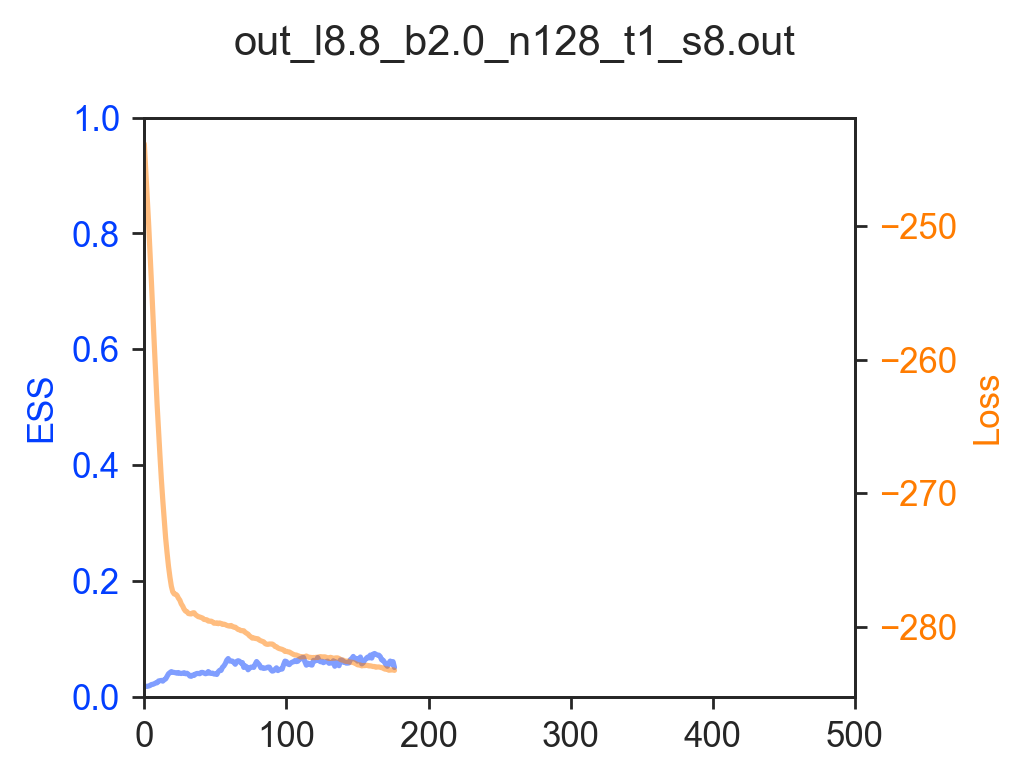

In [ ]:
train_params = {
    'n_era': 5,
    'n_epoch': 100,
    'n_layers': 16,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8, 16, 8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 5,
    'plot_freq': 10,
}

pre_flow_model, flow_act = flow_train(param, **train_params)

### Evaluate trained model and calculate topological susceptibility $\chi_{\mathcal{Q}}$

In [23]:
u1_ens = generate_ensemble(pre_flow_model,flow_act)
pre_flow = pre_flow_model['layers']

### Save `model.state_dict()` to `./pre_flow_model/pre_flow_model_layers.pth`:

In [31]:
model_dir = os.path.join(os.getcwd(), 'pre_flow_model') 
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

layers_file = os.path.join(model_dir, 'pre_flow_model_layers.pth')
torch.save(pre_flow_model['layers'].state_dict(), layers_file)

In [37]:
train_force = False
flow_model = None

if train_force:
    flow_model, flow_act = flow_train(param, with_force=True, pre_model=pre_flow_model)
else:
    flow_model = pre_flow_model
    
u1_ens = generate_ensemble(flow_model,flow_act)
flow = flow_model['layers']
# flow.eval()

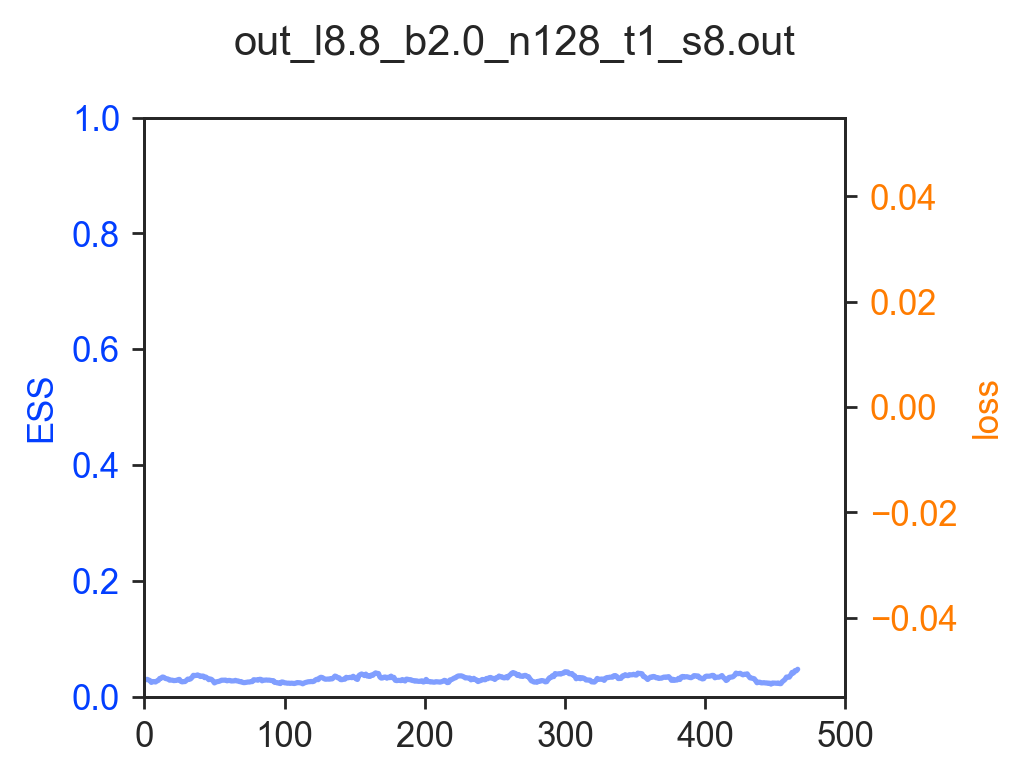

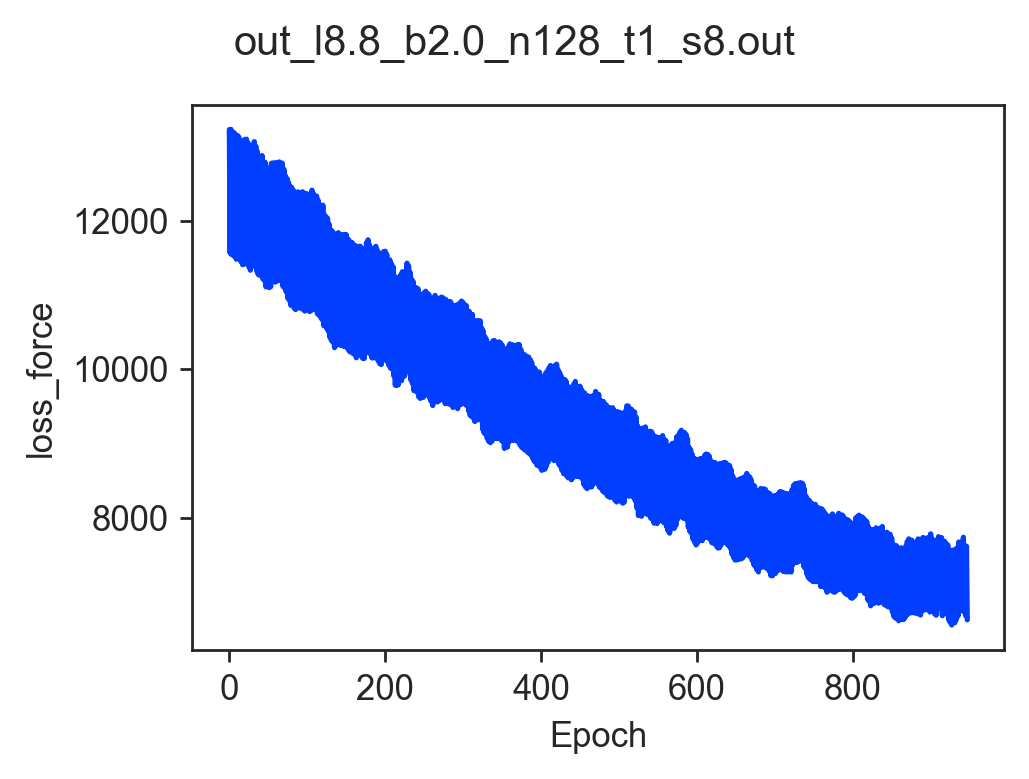

/Users/saforem2/opt/anaconda3/envs/torch-2021-03/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saforem2/opt/anaconda3/envs/torch-2021-03/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


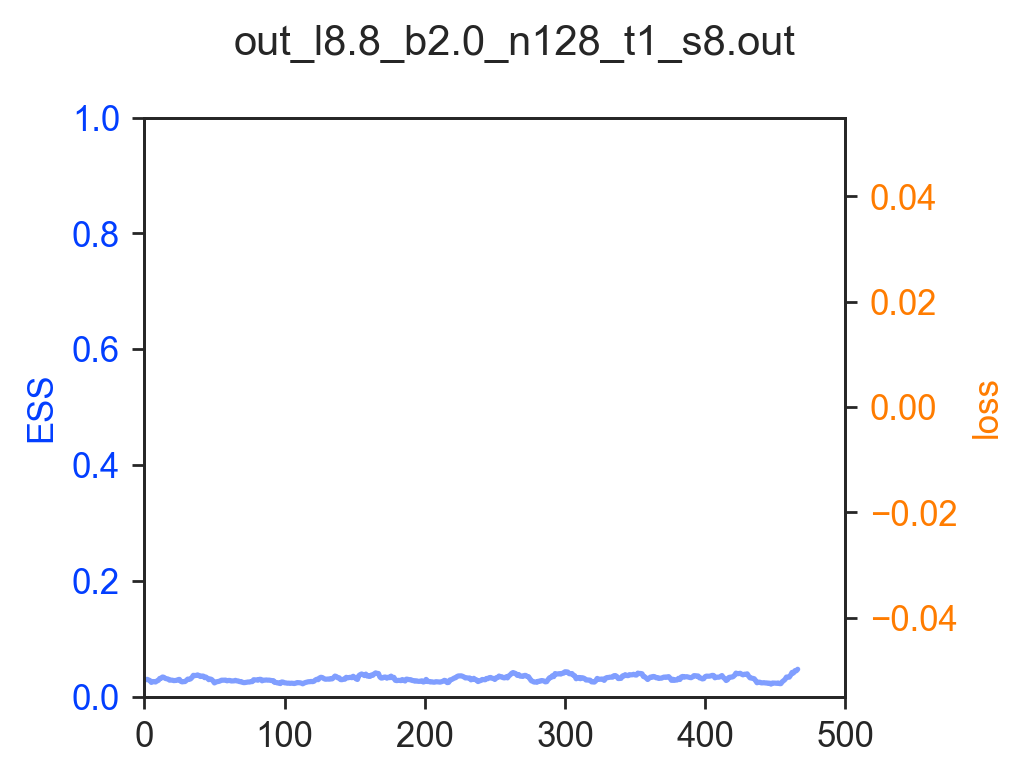

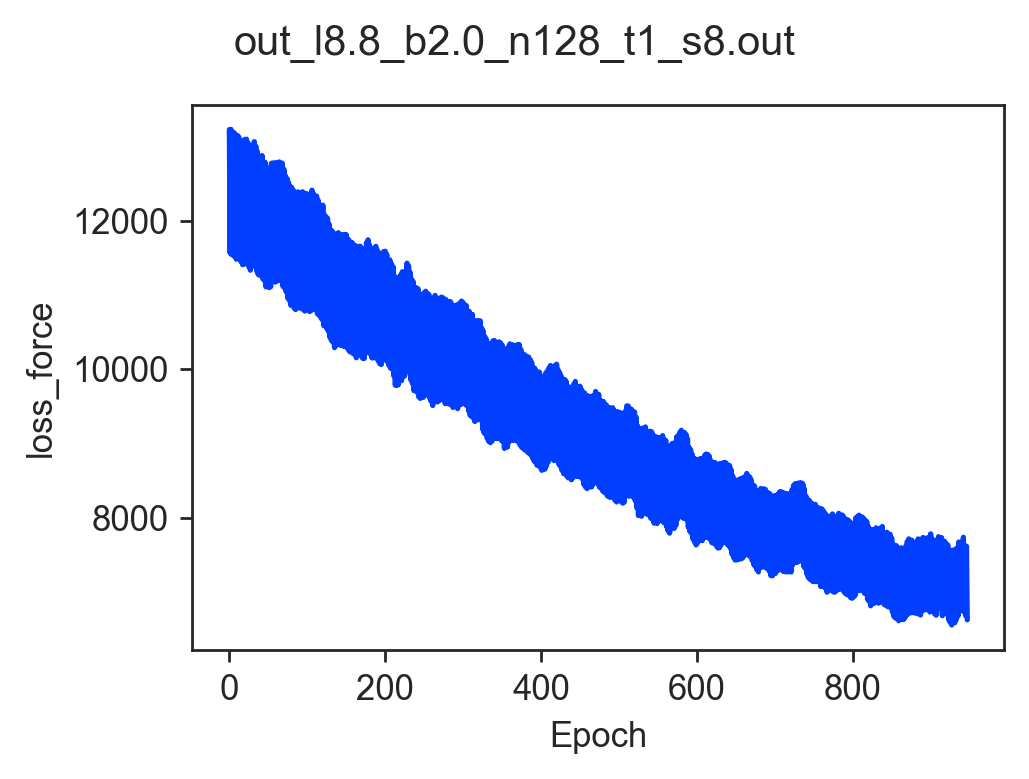

In [40]:
# flow_model_trained_force
flow_model_tf, flow_act_tf = flow_train(param, n_era=5,
                                        with_force=True,
                                        pre_model=pre_flow_model)

### Save the model trained with force:

In [48]:

model_dir = os.path.join(os.getcwd(), 'flow_model_with_force') 
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

layers_file = os.path.join(model_dir, 'flow_model_with_force.pth')
console.log(f'Saving `flow_model_tf` to {layers_file}.')
torch.save(flow_model_tf['layers'].state_dict(), layers_file)

In [41]:
def test_force(
    param: Param,
    model: dict,
    x: torch.Tensor = None,
    pre_model: dict = None
):
    """Test the force."""
    #model = flow_model
    #layers, prior = model['layers'], model['prior']
    if x is None:
        if pre_model is None:
            raise ValueError(f'Either `x` or `pre_model` must be specified.')
            
        pre_xi = pre_model['prior'].sample_n(1)
        x = qed.ft_flow(pre_model['layers'], pre_xi)
        
    xi = qed.ft_flow_inv(model['layers'], x)
    force = qed.ft_force(param, model['layers'], xi)
    force_norm = torch.linalg.norm(force)
    #put(f'ft_force.norm: {f_s:.5g}')
    return force_norm

In [44]:
field_arr = torch.stack(tuple(field), dim=0)
field_arr

tensor([[[-2.8031, -1.8330, -2.1790,  1.9137, -2.4453,  1.3279,  0.5711,
           1.4263],
         [-1.9727,  2.6164,  0.3176,  0.9028,  2.5141, -2.8041,  1.3850,
           2.4901],
         [ 0.0052, -2.4485,  1.9771,  3.1226,  2.7320,  1.4698,  1.7342,
           2.0925],
         [-2.0901,  2.3589, -2.7365,  0.5768, -1.9313, -2.1740,  2.4776,
          -0.5284],
         [ 0.6751, -0.2001,  0.0495,  1.1197,  1.7230, -2.6412, -0.1206,
          -3.1211],
         [ 0.8005,  0.6114, -2.8247,  1.4283,  1.2789,  2.1510, -0.0303,
           1.8293],
         [ 1.4343, -1.6757, -1.9156,  2.3781, -0.3729,  0.9244,  2.3643,
          -0.7306],
         [-1.0474,  1.2417, -1.4384, -2.6722,  1.6608, -1.5958, -0.8418,
           1.5496]],

        [[ 0.1872,  0.1515,  1.5413,  0.4307, -2.6190,  2.1528,  2.2142,
           0.9425],
         [ 1.5283, -0.6613, -0.8731,  1.8080,  0.5348,  0.8017, -2.5918,
          -2.9637],
         [-2.1247, -2.0738, -0.8748, -1.1424,  0.3612, -1.6347, -0.6

In [45]:
field_arr.shape

torch.Size([2, 8, 8])

In [54]:
#test_force(n=1)

#for arr in field_arr:
force_tf = test_force(param, flow_model_tf, pre_model=pre_flow_model)
console.log(f'ft_flow(players, pxi), (pxi ~ pre_prior): {force_tf:.5g}')

x_ = field_arr.squeeze()[None, :]
force_ = test_force(param, flow_model_tf, x=x_, pre_model=pre_flow_model)
console.log(f'ft_flow(layers, field_arr), (pxi ~ pre_prior): {force_:.5g}')

In [55]:
force1 = test_force(param, flow_model_tf, pre_model=pre_flow_model)
force2 = test_force(param, flow_model_tf, x=field_arr[:2].squeeze()[None, :])

force1
force2

tensor(15.7890)

tensor(16.9513)

In [56]:
#test_force(5)
#test_force(torch.reshape(field, (1,)+field.shape))
#test_force(field_arr)
#test_force(field_arr)

In [76]:
fields, metrics = run(param)

In [77]:
#fields_ = torch.tensor([i for i in list(fields.values())])
fields_arr = torch.stack(tuple(fields.values()), dim=0)
#list(fields.values())[0]

In [78]:
field_run = torch.stack(tuple(fields.values()), dim=0)
#flows = flow

put(f'plaq(field_run[0]) {qed.action(param, field_run[0][None, :]) / (-param.beta*param.volume)}')
# field.requires_grad_(True)
x = field_run[0][None, :]
logJ = 0.0
for layer in reversed(flow_model_tf['layers']):
    x, lJ = layer.reverse(x)
    logJ += lJ

# x is the prior distribution now
    
x.requires_grad_(True)
    
y = x
logJy = 0.0
for layer in flow_model_tf['layers']:
    y, lJ = layer.forward(y)
    logJy += lJ
    
s = qed.action(param, y[0][None, :]) - logJy

put(f'logJ: {qed.grab(logJ)}')
put(f'logJy: {qed.grab(logJy)}')
#print(logJ,logJy)


# print("eff_action", s + 136.3786)

put(f'original_action: {qed.action(param, y[0][None, :]) + 91}')
#print("original_action", qed.action(param, y[0][None, :]) + 91)

put(f'eff_action: {s + 56}')
#print("eff_action", {s + 56)

s.backward()

f = x.grad

x.requires_grad_(False)

put(f'plaq(x) {qed.action(param, x[0][None, :]) / (-param.beta*param.volume)}  logJ {qed.grab(logJ)}  force.norm {torch.linalg.norm(f)}')

put(f'plaq(y) {qed.action(param, y[0][None, :]) / (-param.beta*param.volume)}')

put(f'plaq(x) {qed.action(param, field_run[0][None, :]) / (-param.beta*param.volume)}  force.norm {torch.linalg.norm(qed.force(param, field_run[0][None, :]))}')


tensor([[[[5.3393, 2.6794, 0.4112, 5.3615, 5.6674, 2.2010, 5.8445, 5.2318],
          [1.6408, 5.0468, 5.7299, 1.3398, 4.2686, 1.0100, 1.6993, 3.4665],
          [4.8564, 5.3503, 0.6799, 4.2638, 4.4783, 1.9511, 1.1342, 6.2287],
          [4.6366, 1.4681, 4.3734, 0.4539, 1.5210, 5.6188, 1.6622, 3.5021],
          [0.0338, 5.2160, 2.6925, 2.5970, 1.8978, 1.3048, 1.8235, 3.9495],
          [2.8288, 0.3818, 0.7961, 2.3820, 4.9723, 2.4734, 1.3916, 3.9748],
          [3.3617, 4.2409, 0.5973, 4.8807, 1.7101, 0.7007, 4.0581, 1.6610],
          [6.1854, 5.0360, 4.3712, 0.2848, 2.8121, 2.1437, 5.5849, 2.7089]],

         [[5.0280, 3.6007, 5.6076, 2.5773, 3.8307, 2.6616, 1.9090, 4.3670],
          [1.0198, 3.6168, 3.3406, 1.8582, 4.2995, 5.8376, 1.6407, 4.3581],
          [4.9422, 4.0702, 6.1904, 0.8270, 0.4380, 1.5983, 5.3924, 1.8660],
          [4.4106, 1.3555, 3.6465, 0.4635, 2.2847, 2.2542, 2.7327, 1.7104],
          [0.7939, 5.9381, 3.7718, 2.9265, 0.2514, 0.1586, 3.6407, 3.0010],
          

tensor([[[[5.3393, 2.6794, 0.4112, 5.3615, 5.6674, 2.2010, 5.8445, 5.2318],
          [1.6408, 5.0468, 5.7299, 1.3398, 4.2686, 1.0100, 1.6993, 3.4665],
          [4.8564, 5.3503, 0.6799, 4.2638, 4.4783, 1.9511, 1.1342, 6.2287],
          [4.6366, 1.4681, 4.3734, 0.4539, 1.5210, 5.6188, 1.6622, 3.5021],
          [0.0338, 5.2160, 2.6925, 2.5970, 1.8978, 1.3048, 1.8235, 3.9495],
          [2.8288, 0.3818, 0.7961, 2.3820, 4.9723, 2.4734, 1.3916, 3.9748],
          [3.3617, 4.2409, 0.5973, 4.8807, 1.7101, 0.7007, 4.0581, 1.6610],
          [6.1854, 5.0360, 4.3712, 0.2848, 2.8121, 2.1437, 5.5849, 2.7089]],

         [[5.0280, 3.6007, 5.6076, 2.5773, 3.8307, 2.6616, 1.9090, 4.3670],
          [1.0198, 3.6168, 3.3406, 1.8582, 4.2995, 5.8376, 1.6407, 4.3581],
          [4.9422, 4.0702, 6.1904, 0.8270, 0.4380, 1.5983, 5.3924, 1.8660],
          [4.4106, 1.3555, 3.6465, 0.4635, 2.2847, 2.2542, 2.7327, 1.7104],
          [0.7939, 5.9381, 3.7718, 2.9265, 0.2514, 0.1586, 3.6407, 3.0010],
          

In [79]:
put(x.shape)
x = qed.ft_flow_inv(flow, field_run)
# x = field_run
#for layer in reversed(flows):
#    x, lJ = layer.reverse(x)
ff = qed.ft_force(param, flow, x)
put(torch.linalg.norm(ff))
fff = qed.ft_force(param, flow, x)
put(torch.linalg.norm(fff))

In [80]:
x = qed.ft_flow_inv(flow, field_run)
put(qed.grab(qed.ft_action(param, flow, x)))

In [81]:
def flattern(l):
    return [x for y in l for x in y]

def average(l):
    return sum(l) / len(l)

def sub_avg(l):
    avg = average(l)
    return np.array([x - avg for x in l])

In [82]:
ft_hmc_info_list = []
def ft_leapfrog(param, flow, x, p):
    mom_norm = torch.sum(p*p)
    info_list = []
    dt = param.dt
    x_ = x + 0.5*dt*p
    f = qed.ft_force(param, flow, x_)
    p_ = p + (-dt)*f
    info = np.array((float(torch.linalg.norm(f)),
                     float(qed.ft_action(param, flow, x_).detach()),
                     float(torch.sum(p*p_)/np.sqrt(mom_norm*torch.sum(p_*p_)))))
    info_list.append(info)
    for i in range(param.nstep-1):
        x_ = x_ + dt*p_
        f = qed.ft_force(param, flow, x_)
        info = np.array((float(torch.linalg.norm(f)),
                        float(qed.ft_action(param, flow, x_).detach()),
                        float(torch.sum(p*p_)/np.sqrt(mom_norm*torch.sum(p_*p_)))))
        info_list.append(info)
        p_ = p_ + (-dt)*f
    x_ = x_ + 0.5*dt*p_
    info_ = [
        np.sqrt(average([l[0] ** 2 for l in info_list])),
        (info_list[0][1], info_list[-1][1]),
        info_list[-1][2]
    ]
    put(', '.join([f'{i}' for i in info_]))
        
    ft_hmc_info_list.append(info_list)
    return (x_, p_)

def ft_hmc(param, flow, field):
    x = qed.ft_flow_inv(flow, field)
    p = torch.randn_like(x)
    act0 = qed.ft_action(param, flow, x).detach() + 0.5*torch.sum(p*p)
    x_, p_ = ft_leapfrog(param, flow, x, p)
    xr = qed.regularize(x_)
    act = qed.ft_action(param, flow, xr).detach() + 0.5*torch.sum(p_*p_)
    prob = torch.rand([], dtype=torch.float64)
    dH = act - act0
    exp_mdH = torch.exp(-dH)
    acc = prob < exp_mdH
    # ADJUST ME
    newx = xr if acc else x
    # newx = xr
    newfield = qed.ft_flow(flow, newx)
    return (float(dH), float(exp_mdH), acc, newfield)

In [84]:
def ft_run(param, flow, field = None):
    if field == None:
        field = param.initializer()
    ft_hmc_info_list = []
    with open(param.uniquestr(), "w") as O:
        params = param.summary()
        O.write(params)
        put(params)
        plaq = qed.action(param, torch.squeeze(field)) / (-param.beta*param.volume)
        topo = qed.topo_charge(torch.squeeze(field)[None, :])
        #plaq, topo = (qed.action(param, field[None, :]) / (-param.beta*param.volume), qed.topo_charge(field[None, :]))
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        O.write(status)
        put(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                #field_run = torch.reshape(field,(1,)+field.shape)
                
                dH, exp_mdH, acc, field = ft_hmc(param, flow, torch.squeeze(field)[None, :])
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                topo = qed.topo_charge(torch.squeeze(field)[None, :])
                ifacc = "ACCEPT" if acc else "REJECT"
                status = {
                    'traj': f'{n * param.ntraj+i+1:4}',
                    'accept': f'{qed.grab(acc)[0]}',
                    'dH': f'{dH:< 12.8}',
                    'expdH': f'{exp_mdH:< 12.8}',
                    'plaq': f'{plaq:< 12.8}',
                    'topo': f'{qed.grab(topo)[0]:< 3.3}',
                }
                outstr = ', '.join(
                    '='.join((k, v)) for k, v in status.items()
                )
                O.write(outstr + '\n')
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    put(outstr)
            t += timer()
            ts.append(t)
        print("Run times: ", ts)
        print("Per trajectory: ", [t/param.ntraj for t in ts])
    return field

In [85]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow_model['layers'])#, torch.stack(tuple(field.values()), dim=0).squeeze())

Run times:  [19.072179759999926, 19.285480495998854, 18.426215491999756, 18.11961401299959]
Per trajectory:  [4.768044939999982, 4.8213701239997135, 4.606553872999939, 4.529903503249898]


In [87]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field_tf = ft_run(param, flow_model_tf['layers'])#, torch.stack(tuple(field.values()), dim=0).squeeze())

Run times:  [17.987577218000297, 21.978541779999432, 26.334532345999833, 26.49800289900122]
Per trajectory:  [4.496894304500074, 5.494635444999858, 6.583633086499958, 6.624500724750305]


In [32]:
pcaram = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow_model['layers'], field[None, :])

Run times:  [26.76626241199847, 26.914619691999178, 26.190883858000234, 27.22705174299881]
Per trajectory:  [6.691565602999617, 6.7286549229997945, 6.5477209645000585, 6.806762935749703]


In [33]:
action_list = np.array([l[1] for l in flattern(ft_hmc_info_list)])
action_list = sub_avg(action_list)
put(np.sqrt(average(action_list**2)))

In [34]:
force_list = np.array([l[0] for l in flattern(ft_hmc_info_list)])
put(np.sqrt(average(force_list**2)))

In [35]:
put(np.array(force_list[0:300]))

In [36]:
param_new = Param(
    beta = 2.0,
    lat = (12, 12),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

field_new = run(param_new)

In [37]:
def get_nets(layers):
    nets = []
    for l in layers:
        nets.append(l.plaq_coupling.net)
    return nets

In [38]:
from utils.layers import NCPPlaqCouplingLayer, GaugeEquivCouplingLayer
    
def make_u1_equiv_layers_net(*, lattice_shape, nets):
    n_layers = len(nets)
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        net = nets[i]
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off, 
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

In [39]:
len(get_nets(flow))

16

In [40]:
flow_new = make_u1_equiv_layers_net(lattice_shape = param_new.lat, nets = get_nets(flow))

In [41]:
field_new = ft_run(param_new, flow_new)

Run times:  [28.675316277000093, 29.68512157999976, 31.325857158999497, 30.801734333999775]
Per trajectory:  [7.168829069250023, 7.42128039499994, 7.831464289749874, 7.700433583499944]


In [42]:
field_new = ft_run(param_new, flow_new, field_new)

Run times:  [30.429017989001295, 31.480484570000044, 31.58326466699873, 31.587333907000357]
Per trajectory:  [7.607254497250324, 7.870121142500011, 7.8958161667496825, 7.896833476750089]


In [43]:
put(f'action: {qed.action(param, field)}')
put(f'action (new): {qed.action(param_new, field_new)}')